In [8]:
import os
import glob
import numpy as np
import astropy.io as astr
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from matplotlib.ticker import AutoMinorLocator

def MakeDict(data_frame=True):
    """
    Inpunts:
    --------
    No real inputs. Needs to be in the same directory as all of you fits files and the distance_output.file
    that you have the MCFOST outsputs in. 
    
    Outputs:
    --------
    A dictionary of where the ith dictionary element is the 
    
    Wavelength
    Grain Size
    Dust Fraction
    Disc Mass
    Planet Distance in AU 
    Full File Name
    
    for the ith .fits file.
    
    """
    files = sorted(glob.glob('*fits'))
    file_distance = []
    
    ### This dictionary is made from the information read from the MCFOST output files
    dummy_dict = {
        "Wavelength" : [],
        "Grain" : [],
        "D2G" : [],
        "Mass" : [],
        "Planet Distance" : [],
        "Full File Name" : []
    }    
### Opens and reads the file I stored all the MCFOST information in
    with open('distance_output.file') as f:
        distance = f.readlines()
    
    ### This piece is pretty specific to how I read/loaded file names and planet 
    ### distances from the MCFOST files in a Bash script
    for i in range(int(len(distance))):
        if i % 2 == 0:
            file_name = distance[i].strip()
            au = distance[i+1].strip()   

            ### This splitting scheme is also specific to how I named my files from PHANTOM
            splitsies = file_name.split('-')
            dummy_dict['Grain'].append(splitsies[0].replace('GRAIN',''))
            dummy_dict['D2G'].append(splitsies[1].replace('D2G',''))
            dummy_dict['Mass'].append(splitsies[2].replace('MASS',''))
            dummy_dict['Planet Distance'].append(au)
            dummy_dict['Full File Name'].append(file_name)
###
        
        
    ### This is the "Real dictionary" in that this is what gets passed out of the function
    file_dict = {
        "Wavelength" : [],
        "Grain" : [],
        "D2G" : [],
        "Mass" : [],
        "Planet Distance" : [],
        "Full File Name" : []
    }    

    for i in range(len(files)):
        splitsies = files[i].split('-')
        file_dict['Wavelength'].append(splitsies[0])
        file_dict['Grain'].append(splitsies[1].replace('GRAIN',''))
        file_dict['D2G'].append(splitsies[2].replace('D2G',''))
        file_dict['Mass'].append(splitsies[3].replace('MASS','').replace('.fits',''))
        file_dict['Planet Distance'].append(None)
        file_dict['Full File Name'].append(files[i])
###
    
### This compares the dict made from MCFOST with the dict made by directly reading files. 
### The only thing the dummy_dict doesn't load is Wavelength
### The only thing the file_dict doesn't load is Planet Distance
### This could probably be improved

    for j in range(len(dummy_dict['D2G'])):
        for i in range(len(file_dict['D2G'])):
            if file_dict['Grain'][i] == dummy_dict['Grain'][j] and file_dict['D2G'][i] == dummy_dict['D2G'][j]:
                file_dict['Planet Distance'][i] = dummy_dict['Planet Distance'][j]
    
    if data_frame == True:
        return pd.DataFrame(file_dict), len(files)
    
    else:
        return file_dict, len(files)

def easy_Gauss(params,x):
    a, mu, sigma = params
    return a * np.exp(- (x - mu) ** 2 / (2. * sigma ** 2))

def error_ez_Gauss(params, x, y, err, fjac=None):
    
    status=0
    
    return[status, (y - easy_Gauss(params, x)) / err]

def test_Gaussian(x, y, params, parinfo = None, err = 1):
    import mpfit.mpfit
    inputs = {'x': x , 'y': y , 'err': err}
    GaussFit = mpfit.mpfit.mpfit(error_ez_Gauss, params, 
                                functkw = inputs,
                                 parinfo = parinfo,
                                quiet=True, ftol=1e-10,
                               xtol=1e-10, gtol=1e-10)
    return GaussFit.params, GaussFit.perror

def easy_Exponential(params,r):
    k, x = params
    return k*r^(-(x))

def error_ez_Exponential(params, r, y, err, fjac=None):
    
    status = 0
    
    return [Sttus, (y-easy_Exponential(params, r)) / err]

def test_Exponential(x, y, params, parinfo = None, err = 1):
    import mpfit.mpfit
    inputs = {'x': x , 'y': y , 'err': err}
    ExponentialFit = mpfit.mpfit.mpfit(error_ez_Exponential, params, 
                                functkw = inputs,
                                 parinfo = parinfo,
                                quiet=True, ftol=1e-10,
                               xtol=1e-10, gtol=1e-10)
    return ExponentialFit.params, ExponentialFit.perror

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    
    
    
    return radialprofile 


### When I want to edit my gap getting 
### I have really beefed this I think. Lots of this are dependent on the parameters I was globally defining here
def gap_getter(profile, center, planet_locale):
    """
    INPUTS:
    -------
    A Profile
    A Planet location (exterior gap getter for now 1/19/23)
        I want to not need the planet location
    
    OUTPUTS:
    --------
    Returns a Gaussian fit for the input profile. 
    """

    
    length = np.arange(profile.shape[0])
    radius = length * center[0]/profile.shape[0]
    
    planet_index = np.argmin(np.abs(radius - (planet_locale + 0.1*planet_locale)))
        
        
    new_zero_shift = profile[planet_index+1:].max()
    RHS_index = np.nanargmin(np.abs(profile - new_zero_shift))
    RHS = radius[RHS_index]
    
        # Finds a local minima: value and AU and depth
    trunc_profile = profile[:RHS_index]#[planet_index:RHS_index]
    gap_bottom_index = np.nanargmin(trunc_profile)
    gap_bottom_val = trunc_profile[gap_bottom_index]
    gap_bottom_loc = radius[np.nanargmin(np.abs(profile - gap_bottom_val))]
    gap_depth = new_zero_shift - gap_bottom_val
    
    x = radius
    y = -profile + new_zero_shift
        
    ### Gaussian Amplitude 
    amp = gap_depth
    ### Gaussian peak at 
    mu = gap_bottom_loc
    ### Estimating sigma assuming that the distance from mu to the edge is 3*sigma
    sigma = (RHS - gap_bottom_loc)/3
        
    params = np.asarray((amp,mu,sigma))
    constraints =[
                #Amp
                {'limited': [1,1], # enforce lower/upper constraint
                 'limits':  [0.5*params[0], 1.5*params[0]], # lower/upper constraints
                 'fixed': False, # don't let the parameter change
                 'value': params[0]}, 
            
                #Mu
                {'limited': [1,1], 
                 'limits': [1.0*params[1],  1.5*params[1]], 
                 'fixed': False, 
                 'value': params[1]},
                
                #Sigma
                {'limited': [0,1], 
                 'limits': [0.5*params[2], 1.5*params[2]],          
                 'fixed': False,
                 'value': params[2]}]
             
            
    a, b = test_Gaussian(x,y,params,constraints)
    return a,b,[new_zero_shift,gap_bottom_val,gap_bottom_loc]


def plot_fits(file_dict, selection = None, save_png = False, verbose = False, logSpace=True, radiusScale=False,  lBoundary=0, uBoundary=150):
    """
    INPUTS:
    --------
    file_dict: The dictinary made by MakeDict() that you want to loop over 
    selection: An integer of the dictionary element you want to plot/save an image of 
    save_png: Do you want to save all of the plots as named PNGs?
    verbose: Do you want the plots to be shown to you one at a time?
    logSpace/RadisuScale: Plot options
    lBoundary: Lower boundary in AU (use to slice off 0s and NaNs)
    uBoundary: Upper boundary in AU (use to limit area of interest)
    
    
    OUTPUTS:
    --------
    Pngs or a plot
    Maybe nothing lol
    
    """
    ### Early Break
    if selection == None:
        print("What are you doing? \nYou should loop over the dictionary selection you want.")
        return
    
    
    wavelength = file_dict['Wavelength'][selection]
    grain = file_dict['Grain'][selection]
    d2g = file_dict['D2G'][selection]
    mass = file_dict['Mass'][selection]
    filename = file_dict['Full File Name'][selection]
    planet_locale = file_dict['Planet Distance'][selection]
    
    ### Displaying Plot options
    print('Log Space? {}'.format(logSpace))
    print('Scaled with Radius? {}'.format(radiusScale))    
    
    plt.figure()
    
    ### Interfacing with the .fits file 
    hdul = get_pkg_data_filename(filename)
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
        
    ### Getting the radial profile
    center = (data.shape[0]/2,data.shape[1]/2)
    profile = radial_profile(data, center)
        
        ### This becomes the x-axis
    length = np.arange(profile.shape[0])   
    
        
    ### Cutting down profile to Upper and Lower Boundary
    mod_profile = profile[lBoundary:uBoundary]
    normalized_profile = mod_profile/mod_profile.max()
        
    ### This ensures that even when truncated, x-axis is labeled correctly
        ### I have no recollection of what this is intended to do 12-18-2022
        ### Well I have no idea what it is indended to do, but I know what it does
    ### This scales the length array so that it isn't just an array along one dimension
    r_scale = center[0]/profile.shape[0]
    
    ### Non-cosmetic plot options
    if logSpace == True:
        intensity_profile = np.log(normalized_profile)
            
    else:
        intensity_profile = normalized_profile
        
    if radiusScale == True:
        r_squared = length[lBoundary:uBoundary] ** 2
        intensity_profile = normalized_profile * r_squared
    
    title = "Wavelength : {wavelength} // Grain Size : {grain} // D2G : {d2g}"
    label = title.format(grain = grain, d2g = d2g)
   
    ### All of the plotting bits and bobs
    plt.vlines(float(planet_locale), intensity_profile.min(),intensity_profile.max(),color='r')
    plt.plot(length[lBoundary:uBoundary] * r_scale, intensity_profile,label=label)
    
    ### These are purely cosmetic
    plt.tick_params(which='both', width=2)
    plt.tick_params(which='major', length=7)
    plt.tick_params(which='minor', length=4, color='r')
    plt.grid()
    plt.xlabel('AU')
    plt.ylabel('Normalized Intensity')
    plt.grid(which="minor")
    ### The legend basically serves as the title.
    plt.legend()

    if save_png == True:
        picture = "{wavelength}-{grain}-{d2g}-{mass}.png"
        picture_name = picture.format(wavelength = wavelength,
                                 grain = grain,
                                 d2g = d2g,
                                 mass = mass)
        plt.savefig(picture_name)
        
    if verbose == True: 
        plt.show()
        
def AzimuthSweep(file_dict, plot_max = False, selection = None, slices = 36, plots = False):
    """
    Inputs:
    -------
    
    Outputs:
    --------
    """
    if selection == None:
        print("Nothing chosen")
        return 
        
    wavelength = file_dict['Wavelength'][selection]
    grain = file_dict['Grain'][selection]
    d2g = file_dict['D2G'][selection]
    mass = file_dict['Mass'][selection]
    filename = file_dict['Full File Name'][selection]
    planet_locale = float(file_dict['Planet Distance'][selection])
    
    ### Interfacing with the .fits file 
    hdul = get_pkg_data_filename(filename)
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
    center = (data.shape[0]/2,data.shape[1]/2)
    phi_array = np.empty((data.shape[0],data.shape[1]))
    r_array = np.empty((data.shape[0],data.shape[1]))
    y, x = np.indices((data.shape))
    calc_x = x - center[0]
    calc_y = y - center[1]
    
    phi_array = np.arctan2(calc_y, calc_x) * 180 / np.pi
    r_array = np.sqrt((calc_x)**2 + (calc_y)**2)
    
    azimuth_sweep = np.linspace(-180, 180, num=slices)
    gap_widths = np.zeros(slices)
    for i in range(slices):

        if i == len(azimuth_sweep)-1:
            j = 0
        else:
            j = i + 1
            mask_min = azimuth_sweep[i]
            mask_max = azimuth_sweep[j]
            mask = (phi_array > mask_min) & (phi_array <= mask_max+0.1)
        
        masked_data = data[mask]
        masked_r = r_array[mask].astype(np.int)
        tbin = np.bincount(masked_r.ravel(), masked_data.ravel())
        nr = np.bincount(masked_r.ravel())
        bad_radial_profile = np.log(tbin/nr)
        sub_radial_profile = bad_radial_profile[~np.isnan(bad_radial_profile)]
        
        
        ### By packaging this up, I have severly hamstrung the graphing utilities
        ### I'm going to fix this by passing a set of packed graphing utilities
        a, b, c = gap_getter(sub_radial_profile,center, planet_locale)
        ### This is weird.
        ### C = [new_zero_shift,gap_bottom_val,gap_bottom_loc]
        
        FWHM =  2*np.sqrt(2*np.log(2))*a[2]
        gap_widths[i] = FWHM
        if plots == True:
            length = np.arange(sub_radial_profile.shape[0])
            radius = length * center[0]/sub_radial_profile.shape[0]
            
            plt.title('Intensiety Gap Width and Gap Depth')
            plt.plot(radius,sub_radial_profile)
            plt.hlines(c[0],radius.min(),radius.max(), color='g')
            plt.vlines(c[2], c[1], c[0], color='red')    
            plt.vlines(planet_locale,sub_radial_profile.min(),sub_radial_profile.max(), color='black') 
        
            gauss = easy_Gauss(a, radius)
        
            plt.plot(radius,-gauss+c[0], c='r')
            plt.show()
        
    if plot_max == True:
        index_max = np.argmax(gap_widths)
        j = index_max + 1
        
        ### Maybe I could make this it's own function? IDK
        mask_min = azimuth_sweep[index_max]
        mask_max = azimuth_sweep[j]
        mask = (phi_array > mask_min) & (phi_array <= mask_max+0.1)
        masked_data = data[mask]
        masked_r = r_array[mask].astype(np.int)
        tbin = np.bincount(masked_r.ravel(), masked_data.ravel())
        nr = np.bincount(masked_r.ravel())
        bad_radial_profile = np.log(tbin/nr)
        sub_radial_profile = bad_radial_profile[~np.isnan(bad_radial_profile)] 
        length = np.arange(sub_radial_profile.shape[0])
        radius = length * center[0]/sub_radial_profile.shape[0]
        a2, b2, c2 = gap_getter(sub_radial_profile,center, planet_locale)
        ### C = [new_zero_shift,gap_bottom_val,gap_bottom_loc,x]
        
        figure, ax = plt.subplots(figsize=(8, 6))
        plt.title('Intensiety Gap Width and Gap Depth (Selectively Plotting the Max)')
        plt.plot(radius,sub_radial_profile,label = filename)
        plt.hlines(c2[0],radius.min(),radius.max(), color='g')
        plt.vlines(c2[2], c2[1], c2[0], color='red')    
        plt.vlines(planet_locale,sub_radial_profile.min(),sub_radial_profile.max(), color='black') 
        plt.legend()
        gauss = easy_Gauss(a2, radius)
        
        plt.plot(radius,-gauss+c2[0], c='r')
        plt.show()
            
        
    return gap_widths, gap_widths.max()


def log_fit_Subtractor(file_dict, plot_max = False, selection = None):
    """
    Inputs:
    -------
    
    Outputs:
    --------
    
    """
    wavelength = file_dict['Wavelength'][selection]
    grain = file_dict['Grain'][selection]
    d2g = file_dict['D2G'][selection]
    mass = file_dict['Mass'][selection]
    filename = file_dict['Full File Name'][selection]
    planet_locale = float(file_dict['Planet Distance'][selection])
    
    ### Interfacing with the .fits file 
    hdul = get_pkg_data_filename(filename)
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
    center = (data.shape[0]/2,data.shape[1]/2)
    
    
    y, x = np.indices((data.shape))
    calc_x = x - center[0]
    calc_y = y - center[1]
    
    profile = radial_profile(data, center)
    ### This becomes the x-axis
    length = np.arange(profile.shape[0])   
    
    

In [3]:
file_dict, lengths = MakeDict()

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


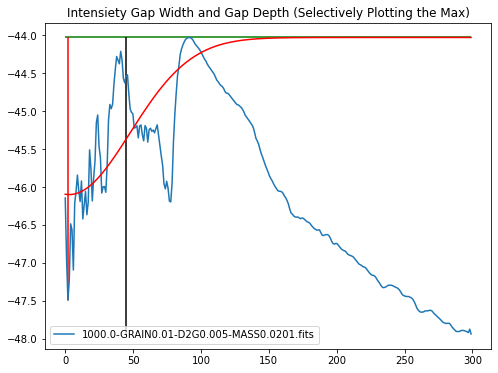

The Max gap width from the 10 degree azimuth slices is 

    105.61485251799938 for file 1000.0-GRAIN0.01-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


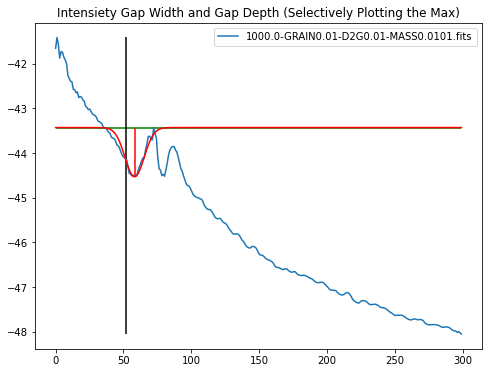

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    16.53886988148827 for file 1000.0-GRAIN0.01-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


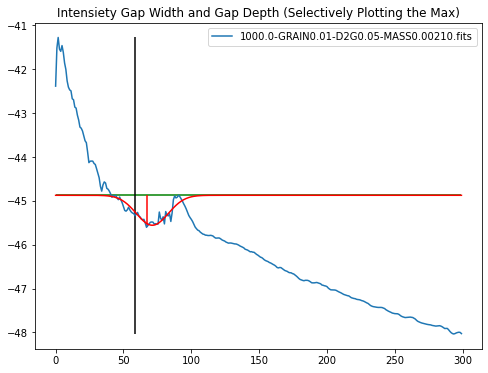

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    27.769104304610252 for file 1000.0-GRAIN0.01-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


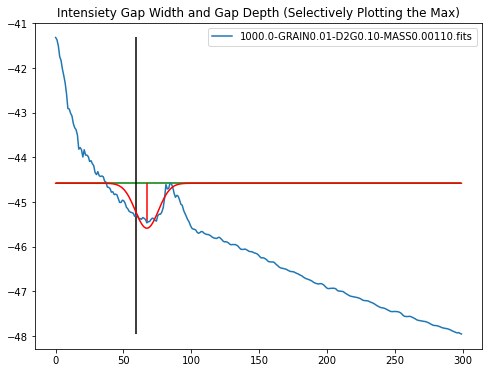

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    20.082913427521465 for file 1000.0-GRAIN0.01-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


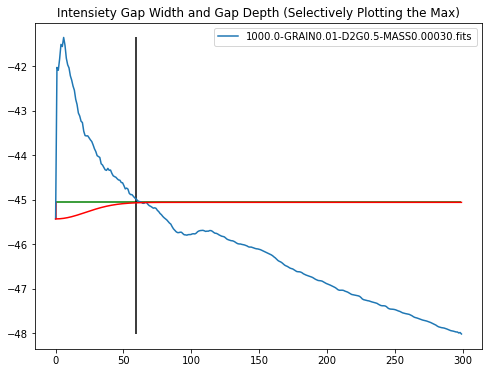

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    51.89899441351105 for file 1000.0-GRAIN0.01-D2G0.5-MASS0.00030.fits


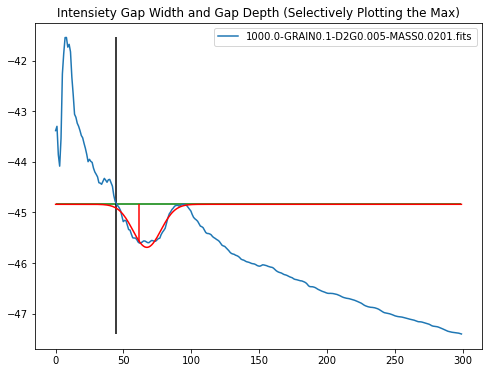

The Max gap width from the 10 degree azimuth slices is 

    24.215299527192194 for file 1000.0-GRAIN0.1-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


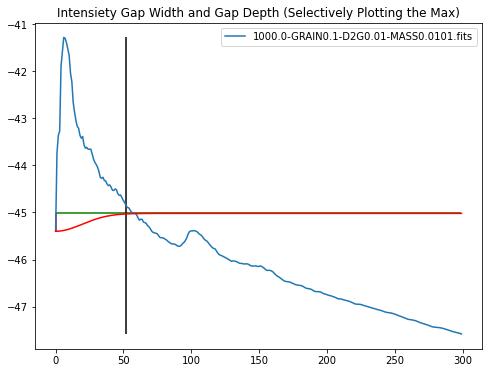

The Max gap width from the 10 degree azimuth slices is 

    46.15760221157011 for file 1000.0-GRAIN0.1-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


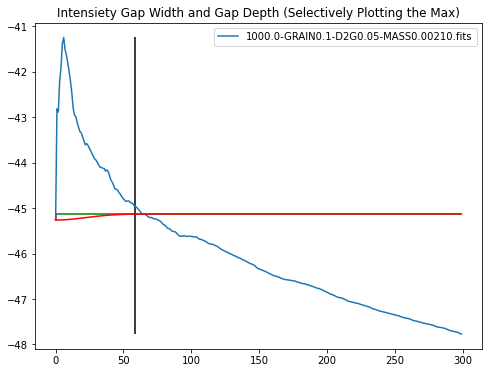

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    51.46295462650419 for file 1000.0-GRAIN0.1-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


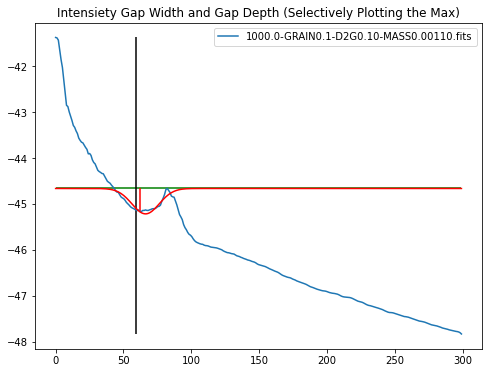

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    23.626956973554663 for file 1000.0-GRAIN0.1-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


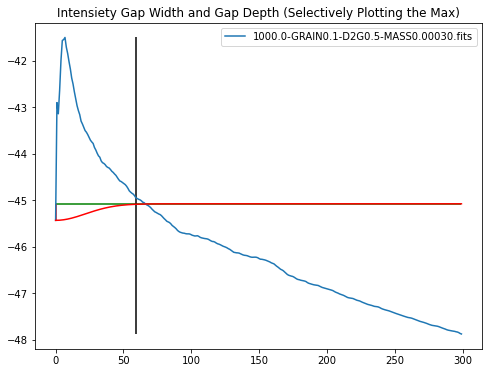

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    51.89899441351105 for file 1000.0-GRAIN0.1-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


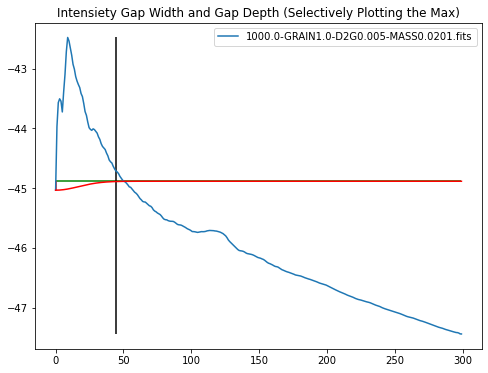

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    39.50520470282185 for file 1000.0-GRAIN1.0-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


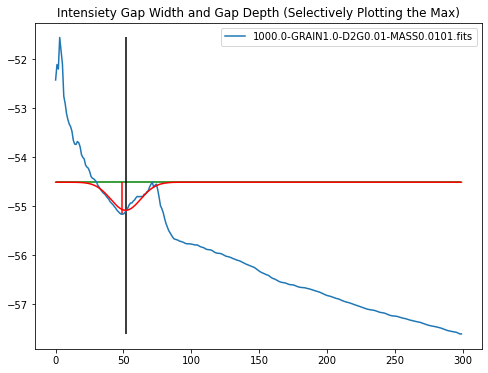

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    25.989652670910143 for file 1000.0-GRAIN1.0-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


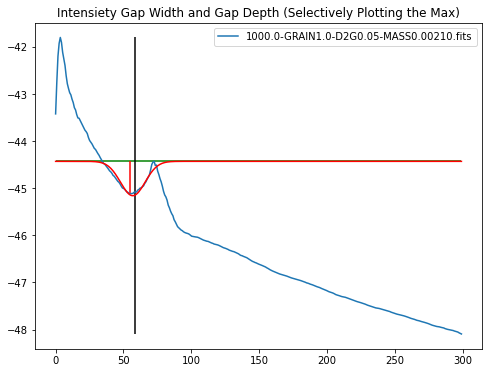

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    21.376608477946654 for file 1000.0-GRAIN1.0-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


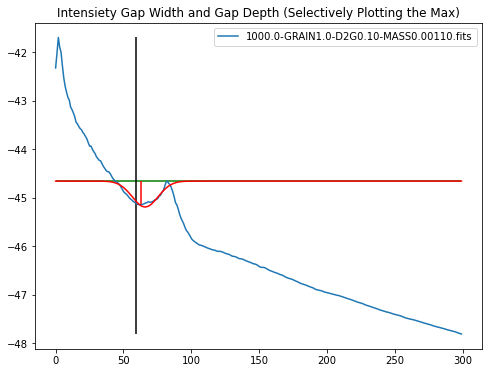

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    22.445609124876935 for file 1000.0-GRAIN1.0-D2G0.10-MASS0.00110.fits


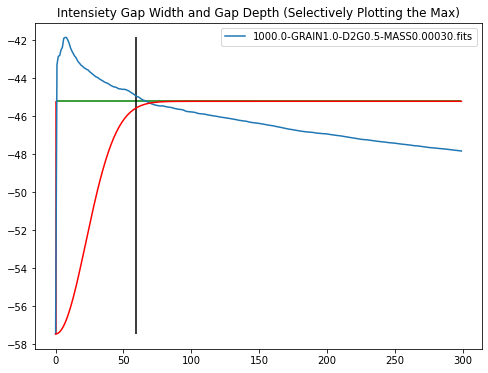

The Max gap width from the 10 degree azimuth slices is 

    52.416260138562656 for file 1000.0-GRAIN1.0-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


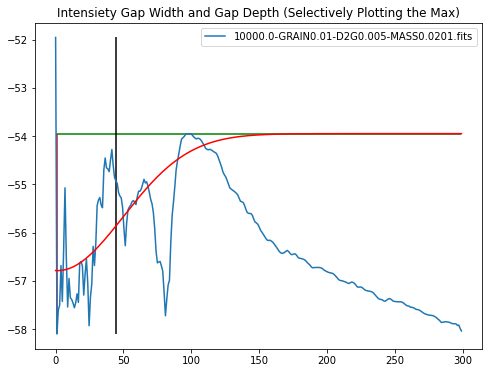

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    113.8679429669571 for file 10000.0-GRAIN0.01-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


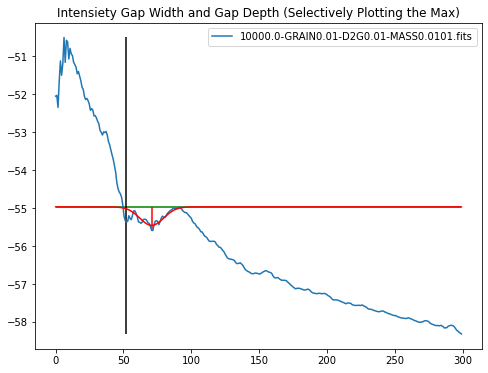

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    20.763315059466475 for file 10000.0-GRAIN0.01-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


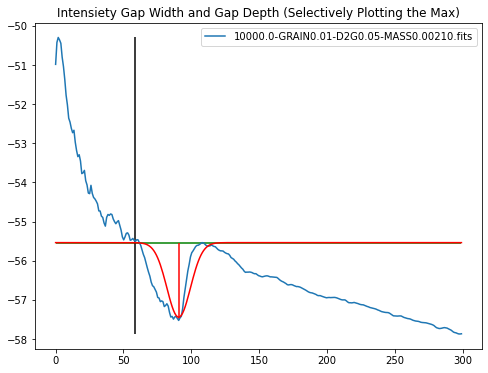

The Max gap width from the 10 degree azimuth slices is 

    20.44377531055808 for file 10000.0-GRAIN0.01-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


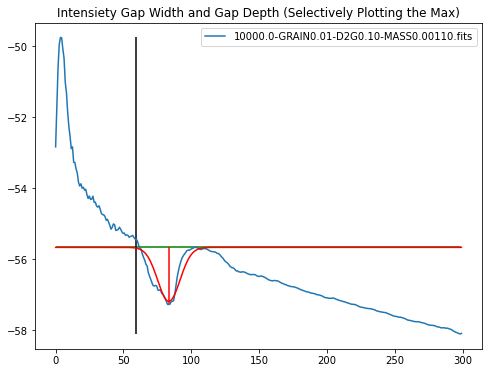

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    19.42208284366555 for file 10000.0-GRAIN0.01-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


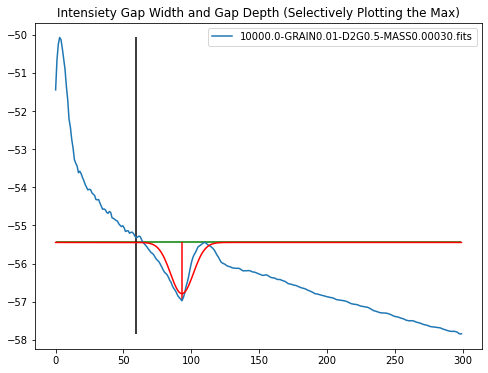

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    19.817792458181252 for file 10000.0-GRAIN0.01-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


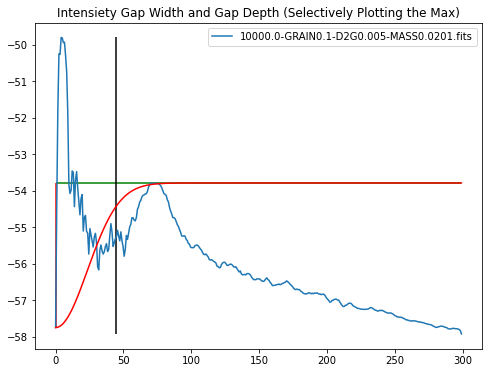

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    55.03112061757109 for file 10000.0-GRAIN0.1-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


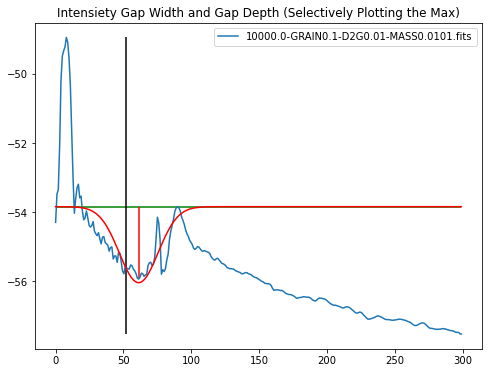

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    33.69561577593628 for file 10000.0-GRAIN0.1-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


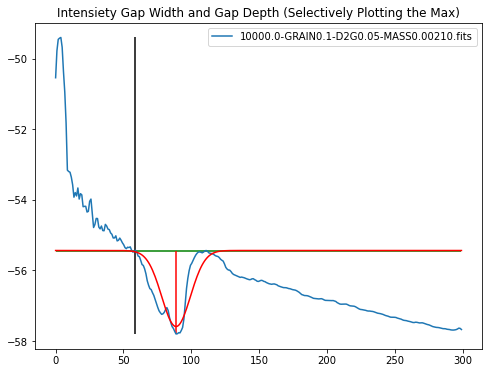

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    24.849391119375216 for file 10000.0-GRAIN0.1-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


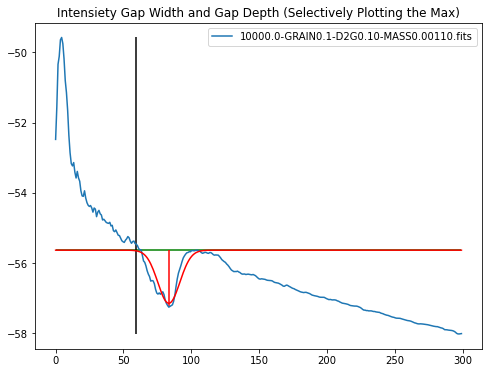

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    19.09726205699112 for file 10000.0-GRAIN0.1-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


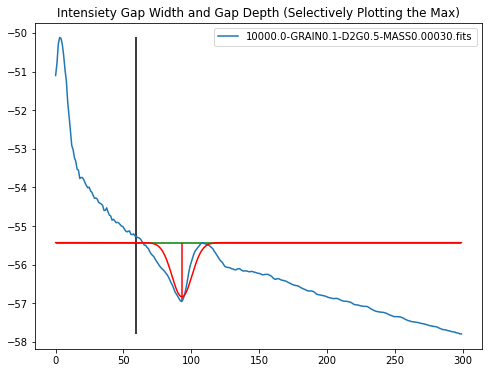

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    17.48628746310111 for file 10000.0-GRAIN0.1-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


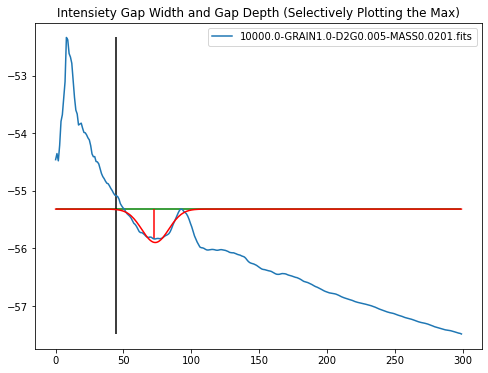

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    23.392252102956455 for file 10000.0-GRAIN1.0-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


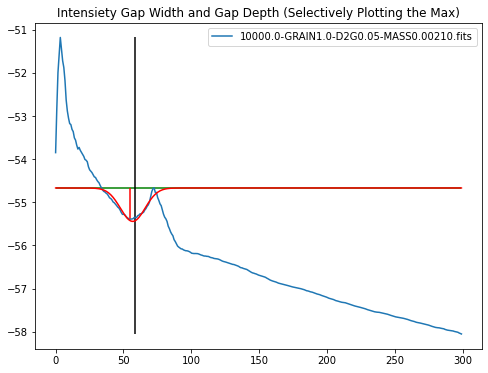

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    21.376608477946654 for file 10000.0-GRAIN1.0-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


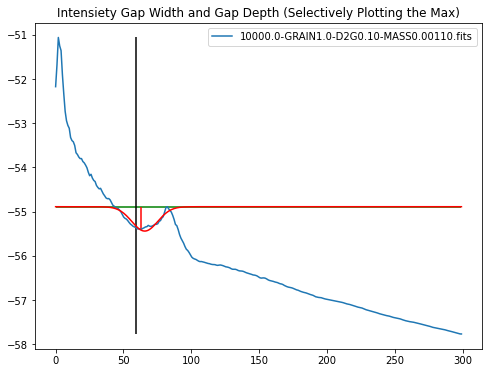

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    22.445609124876935 for file 10000.0-GRAIN1.0-D2G0.10-MASS0.00110.fits


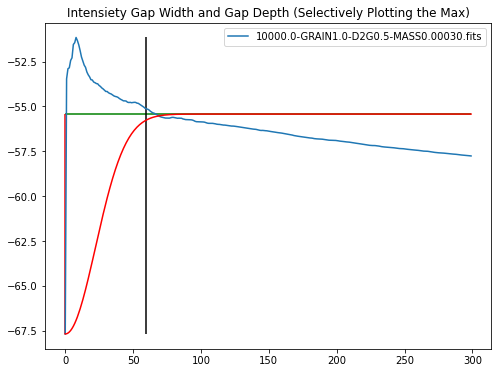

The Max gap width from the 10 degree azimuth slices is 

    52.416260138562656 for file 10000.0-GRAIN1.0-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


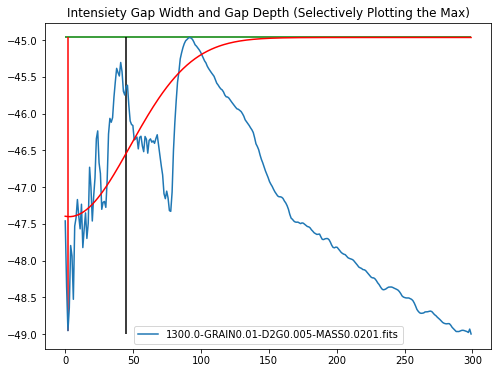

The Max gap width from the 10 degree azimuth slices is 

    105.61485251799938 for file 1300.0-GRAIN0.01-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


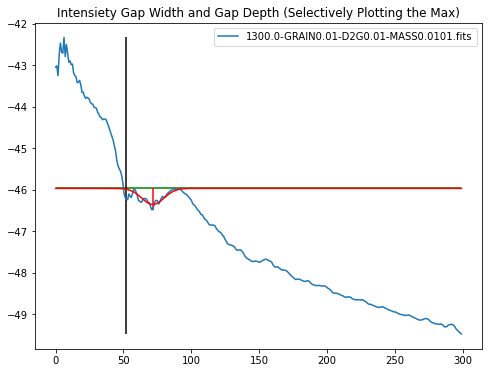

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    19.24079627209398 for file 1300.0-GRAIN0.01-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


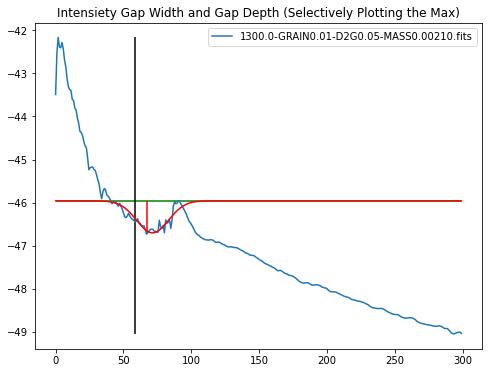

The Max gap width from the 10 degree azimuth slices is 

    27.769104304610252 for file 1300.0-GRAIN0.01-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


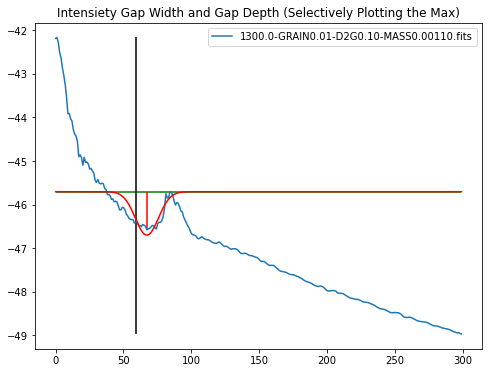

The Max gap width from the 10 degree azimuth slices is 

    20.082913427521465 for file 1300.0-GRAIN0.01-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


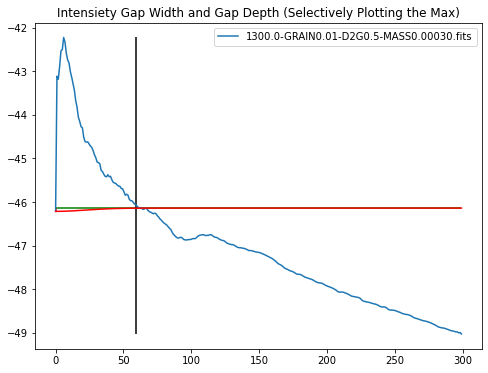

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    51.89899441351105 for file 1300.0-GRAIN0.01-D2G0.5-MASS0.00030.fits


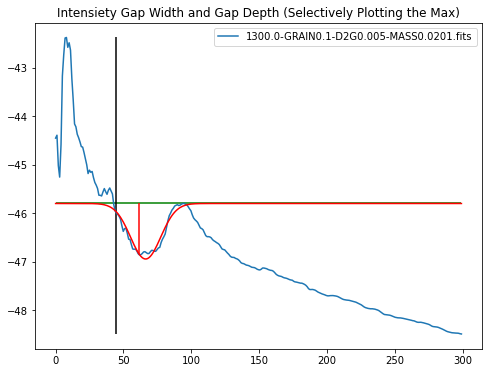

The Max gap width from the 10 degree azimuth slices is 

    26.1386382975062 for file 1300.0-GRAIN0.1-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


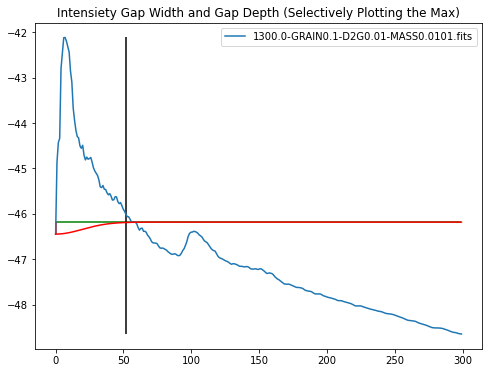

The Max gap width from the 10 degree azimuth slices is 

    46.15760221157011 for file 1300.0-GRAIN0.1-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


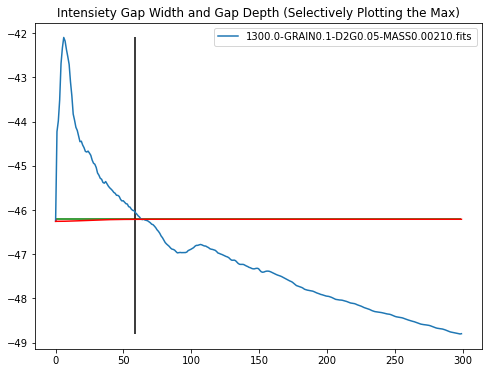

The Max gap width from the 10 degree azimuth slices is 

    50.85159565681453 for file 1300.0-GRAIN0.1-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


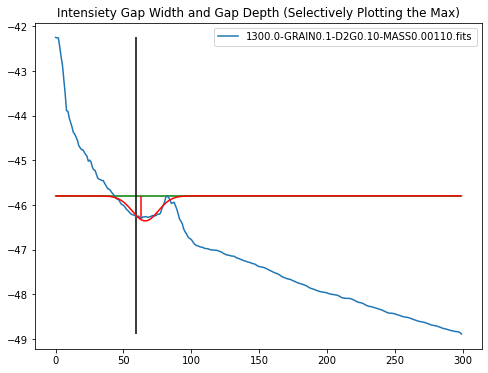

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    22.445609124876935 for file 1300.0-GRAIN0.1-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


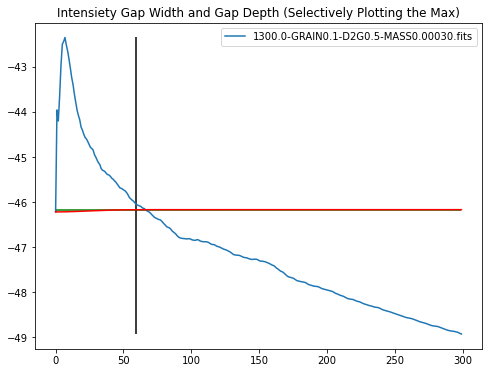

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    51.89899441351105 for file 1300.0-GRAIN0.1-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


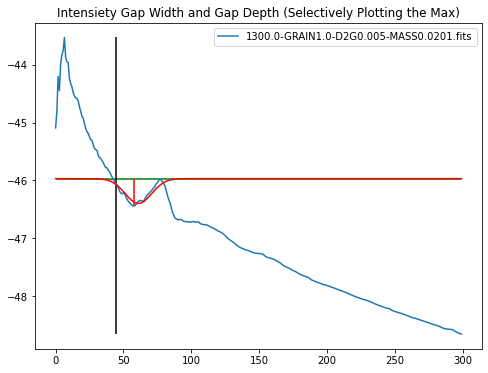

The Max gap width from the 10 degree azimuth slices is 

    22.894083771134227 for file 1300.0-GRAIN1.0-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


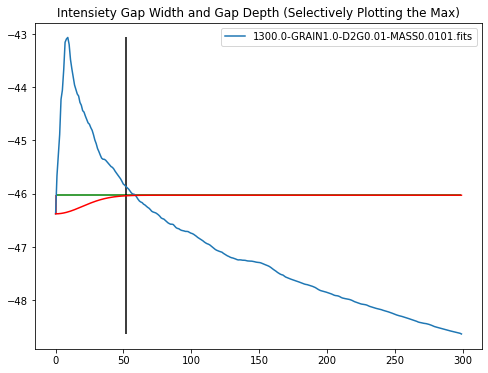

The Max gap width from the 10 degree azimuth slices is 

    46.15760221157011 for file 1300.0-GRAIN1.0-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


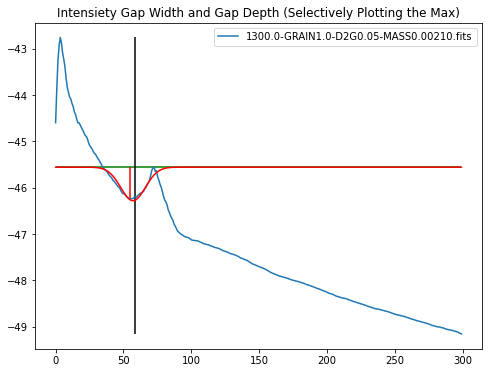

The Max gap width from the 10 degree azimuth slices is 

    21.376608477946654 for file 1300.0-GRAIN1.0-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


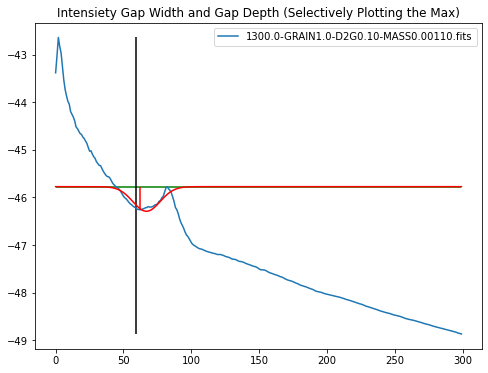

The Max gap width from the 10 degree azimuth slices is 

    23.626956973554663 for file 1300.0-GRAIN1.0-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


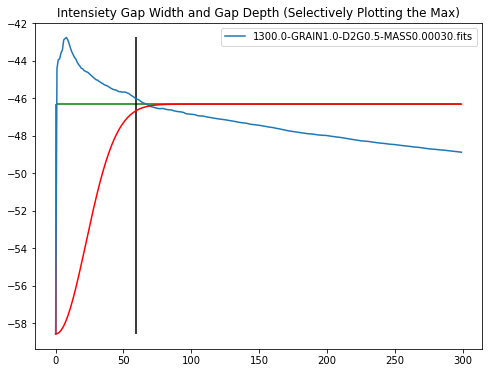

The Max gap width from the 10 degree azimuth slices is 

    52.416260138562656 for file 1300.0-GRAIN1.0-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


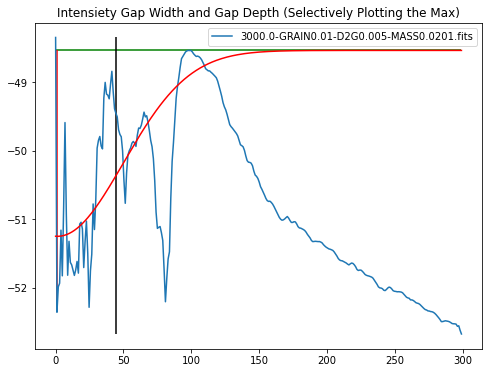

The Max gap width from the 10 degree azimuth slices is 

    113.8679429669571 for file 3000.0-GRAIN0.01-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


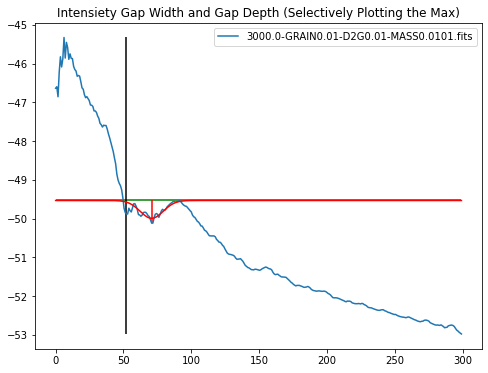

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    20.065453603902082 for file 3000.0-GRAIN0.01-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


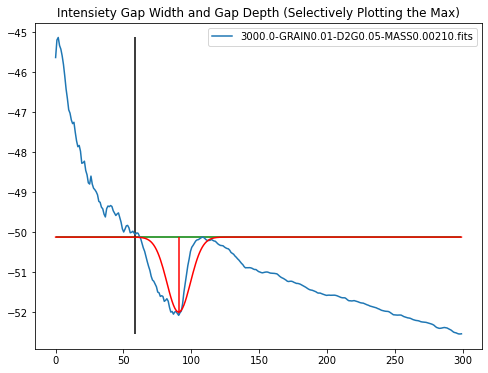

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    20.44377531055808 for file 3000.0-GRAIN0.01-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


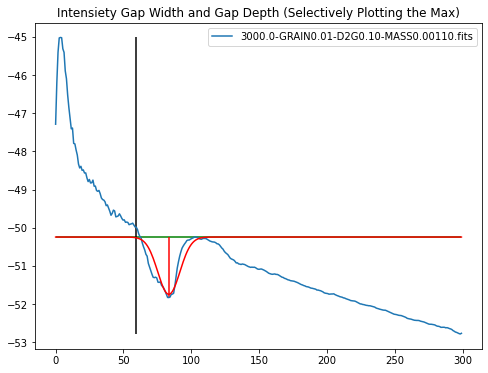

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    19.24975901911709 for file 3000.0-GRAIN0.01-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


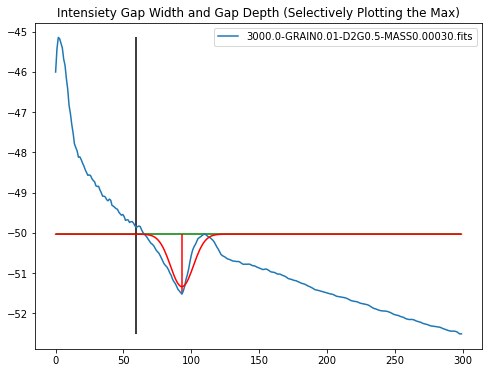

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    19.817792458181252 for file 3000.0-GRAIN0.01-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


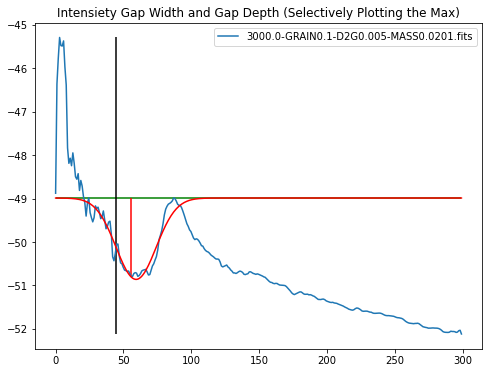

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    34.70538114060457 for file 3000.0-GRAIN0.1-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


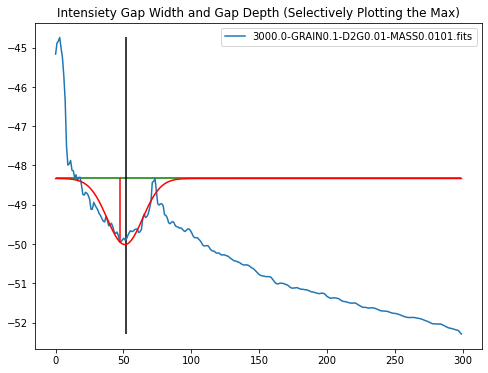

The Max gap width from the 10 degree azimuth slices is 

    30.71504406562108 for file 3000.0-GRAIN0.1-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


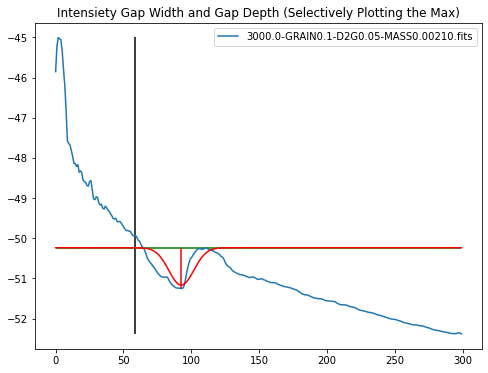

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    21.57954060558908 for file 3000.0-GRAIN0.1-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


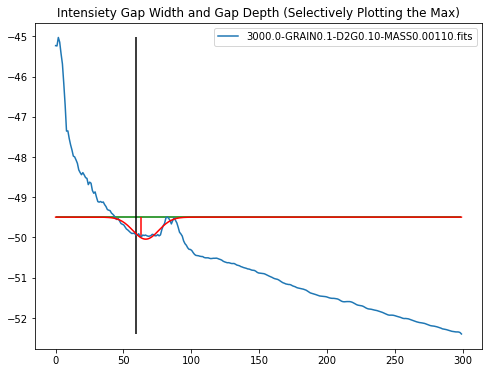

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    22.445609124876935 for file 3000.0-GRAIN0.1-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


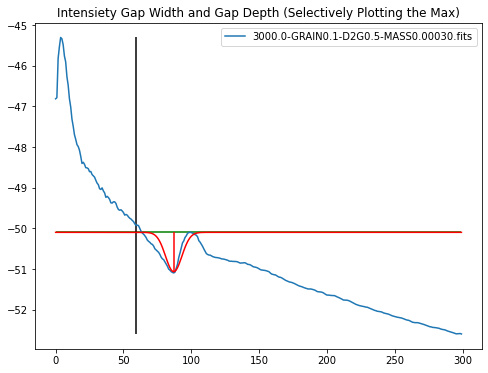

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    14.172528048797382 for file 3000.0-GRAIN0.1-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


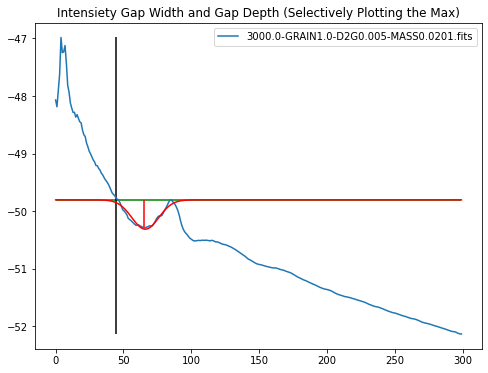

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    23.315049950801484 for file 3000.0-GRAIN1.0-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


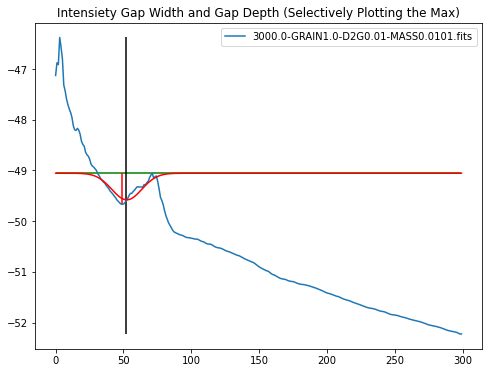

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    25.989652670910143 for file 3000.0-GRAIN1.0-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


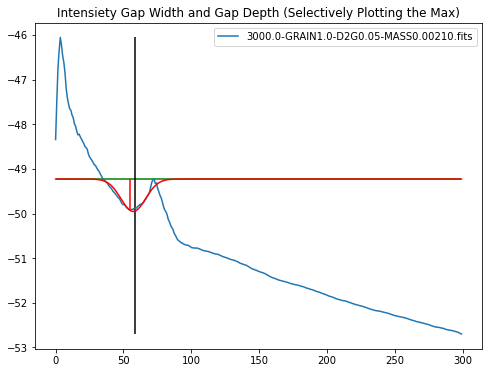

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    21.376608477946654 for file 3000.0-GRAIN1.0-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


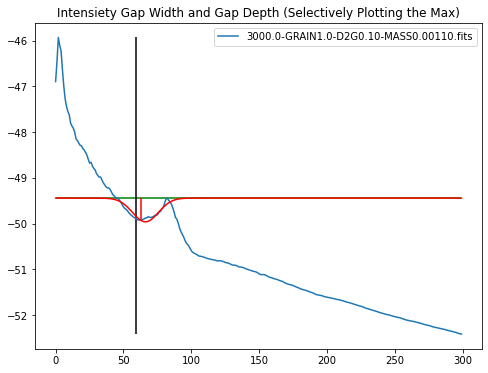

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    22.445609124876935 for file 3000.0-GRAIN1.0-D2G0.10-MASS0.00110.fits


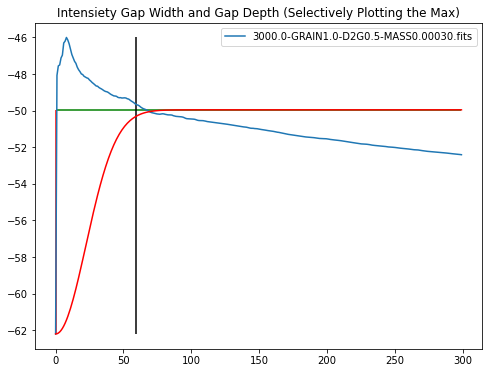

The Max gap width from the 10 degree azimuth slices is 

    52.416260138562656 for file 3000.0-GRAIN1.0-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


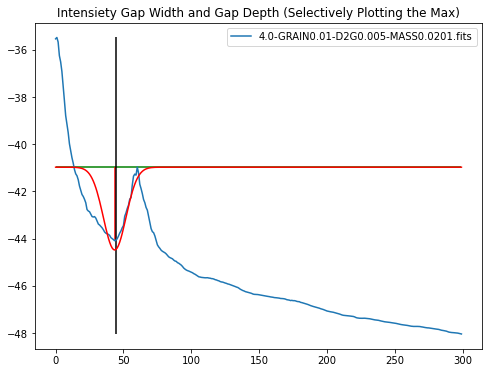

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    19.62350037525791 for file 4.0-GRAIN0.01-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


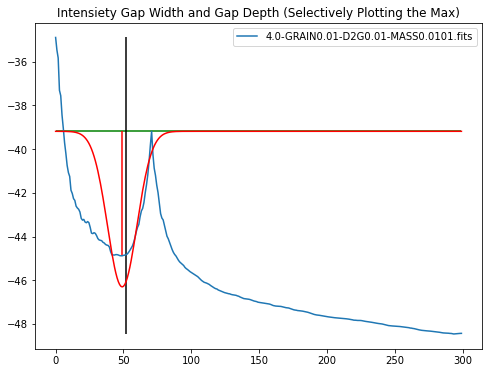

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    25.547575960241435 for file 4.0-GRAIN0.01-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


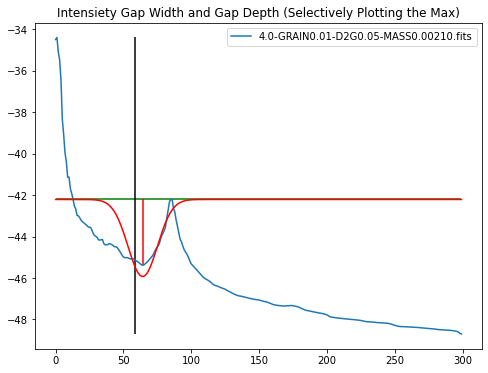

The Max gap width from the 10 degree azimuth slices is 

    25.562191278296496 for file 4.0-GRAIN0.01-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)
<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


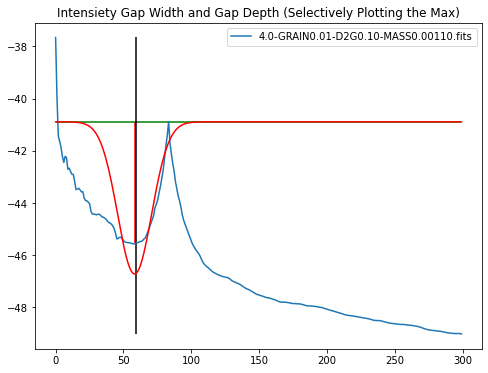

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    29.533696216943337 for file 4.0-GRAIN0.01-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


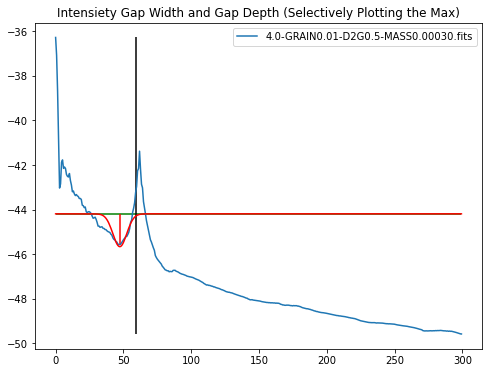

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    12.022493548787429 for file 4.0-GRAIN0.01-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


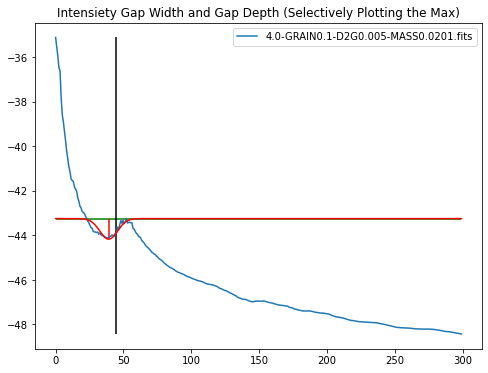

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    15.357522032810536 for file 4.0-GRAIN0.1-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


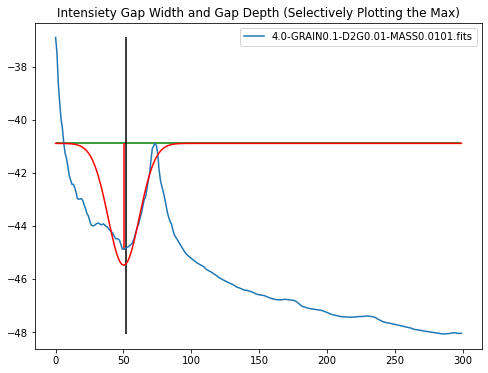

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    27.17100051958788 for file 4.0-GRAIN0.1-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


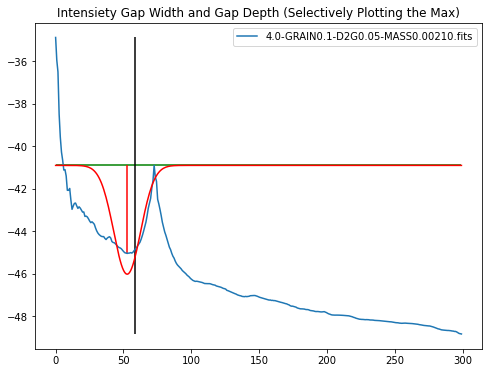

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    23.412475952036814 for file 4.0-GRAIN0.1-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


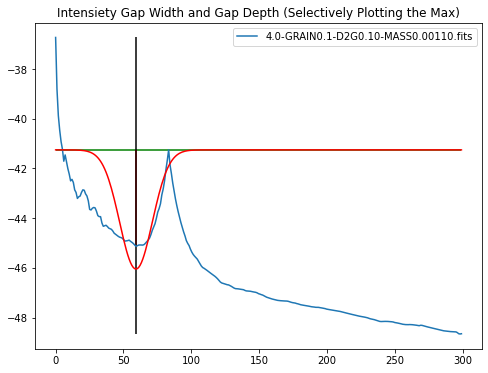

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    28.35234836826561 for file 4.0-GRAIN0.1-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


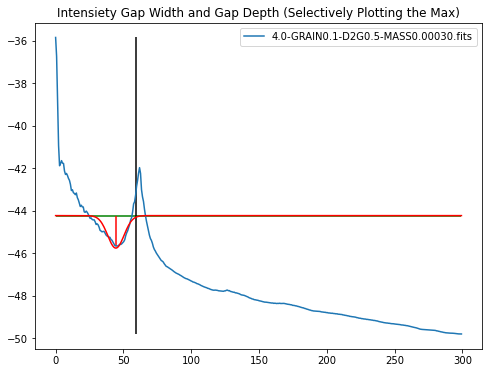

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    14.228929348079134 for file 4.0-GRAIN0.1-D2G0.5-MASS0.00030.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


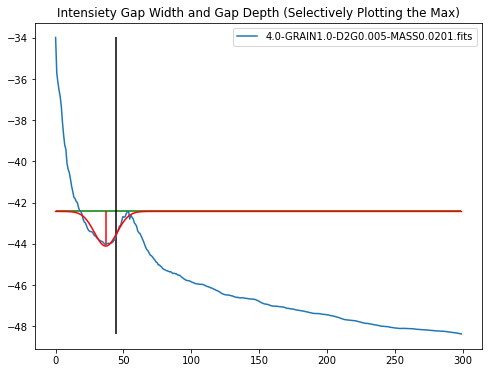

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    19.788403739755882 for file 4.0-GRAIN1.0-D2G0.005-MASS0.0201.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


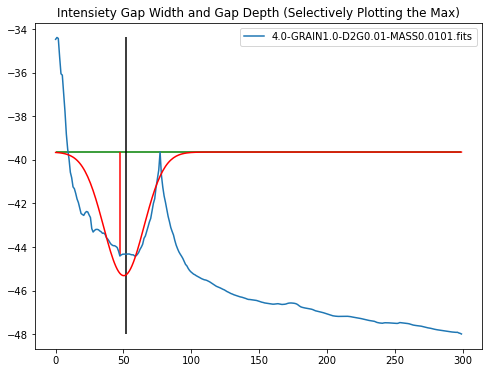

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    34.85753356131339 for file 4.0-GRAIN1.0-D2G0.01-MASS0.0101.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


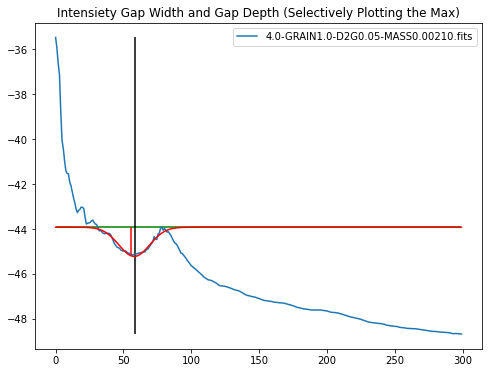

<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


The Max gap width from the 10 degree azimuth slices is 

    26.65834013242585 for file 4.0-GRAIN1.0-D2G0.05-MASS0.00210.fits


<ipython-input-2-ae9ab86c7675>:394: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


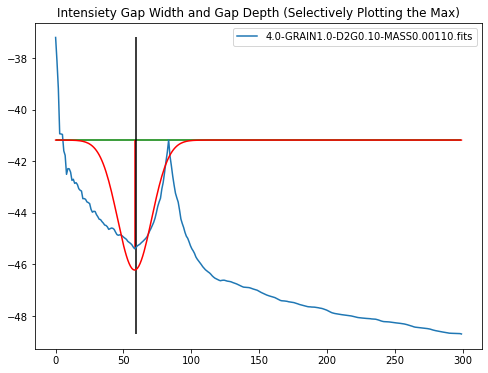

The Max gap width from the 10 degree azimuth slices is 

    29.533696216943337 for file 4.0-GRAIN1.0-D2G0.10-MASS0.00110.fits


<ipython-input-2-ae9ab86c7675>:355: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


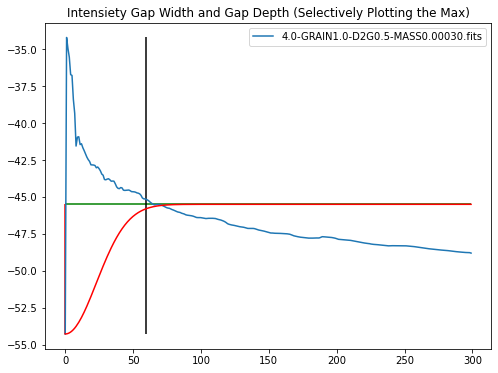

The Max gap width from the 10 degree azimuth slices is 

    53.980924620310795 for file 4.0-GRAIN1.0-D2G0.5-MASS0.00030.fits
We've had 74 many plots


In [4]:
max_width_info = []
chimble = []
for i in range(lengths):
    a,b = AzimuthSweep(file_dict, plot_max = True, selection = i)
    wavelength = float(file_dict['Wavelength'][i])
    grain = float(file_dict['Grain'][i])
    d2g = float(file_dict['D2G'][i])
    mass = float(file_dict['Mass'][i])
    filename = file_dict['Full File Name'][i]
    planet_locale = float(file_dict['Planet Distance'][i])
    
    print("""The Max gap width from the 10 degree azimuth slices is \n
    {gap_width} for file {filename}""".format(gap_width = b,filename=filename))
    info = (wavelength,d2g,grain,b)
    max_width_info.append(info)
    Total = i + 1
master_info = np.asarray(max_width_info)
print("We've had {} many plots".format(Total))

In [5]:
wavelength_long = [*set(master_info[:,0])]
d2g_long = sorted([*set(master_info[:,1])])
grain_long = sorted([*set(master_info[:,2])])

from_array = pd.MultiIndex.from_arrays(master_info.T[:-1], names=('Wavelength','Grain','D2G'))
df = pd.Series(master_info.T[-1],index=from_array)
### This is it
### If I can perfect "tripe"'s shape then wavelength-d2g-grain-gap is the perfect dataframe
## RN first index is wavelength 1-18-23
for i in range(len(df[4.0])):
    index = df[4.0].index[i]
    print(df[4.0][index[0]][index[1]],index[0],index[1])
### New problem: D2G is not sorted for the series
### I think there's a way to plot this

19.62350037525791 0.005 0.01
25.547575960241435 0.01 0.01
25.562191278296496 0.05 0.01
29.533696216943337 0.1 0.01
12.022493548787429 0.5 0.01
15.357522032810536 0.005 0.1
27.17100051958788 0.01 0.1
23.412475952036814 0.05 0.1
28.35234836826561 0.1 0.1
14.228929348079134 0.5 0.1
19.788403739755882 0.005 1.0
34.85753356131339 0.01 1.0
26.65834013242585 0.05 1.0
29.533696216943337 0.1 1.0
53.980924620310795 0.5 1.0


In [6]:
from_array = pd.MultiIndex.from_arrays(master_info.T[:-1], names=('Wavelength','D2G','Grain'))
df2 = pd.DataFrame(master_info.T[-1],index=from_array)
df2.sort_values(by=['Wavelength','D2G'])


0
Wavelength D2G   Grain           
4.0        0.005 0.01   19.623500
                 0.10   15.357522
                 1.00   19.788404
           0.010 0.01   25.547576
                 0.10   27.171001
...                           ...
10000.0    0.100 0.10   19.097262
                 1.00   22.445609
           0.500 0.01   19.817792
                 0.10   17.486287
                 1.00   52.416260

[74 rows x 1 columns]

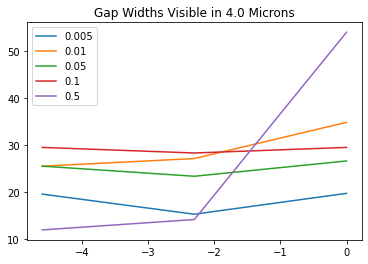

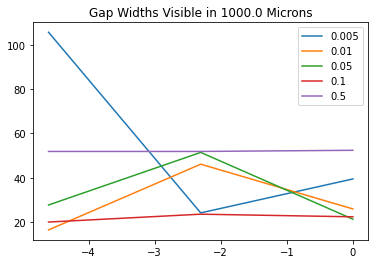

*SCREAMS*
The Culprit: 0.01


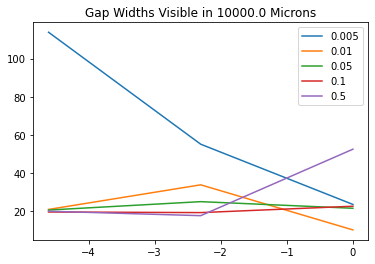

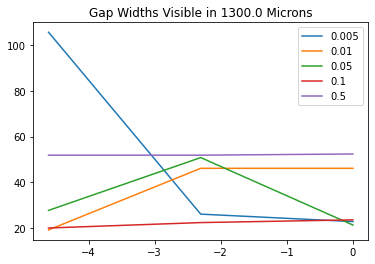

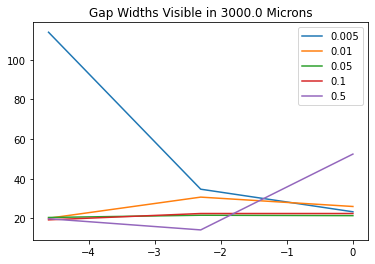

In [7]:
for i in enumerate(wavelength_long):
    for j in enumerate(d2g_long):
        
        gaps = df2[0][i[1]][j[1]].to_numpy()
        
        if len(gaps) < 3:
            print('*SCREAMS*')
            print("The Culprit: {d2g}".format(d2g=d2g_long[j[0]]))
            gaps = np.append(gaps,10)
        plt.plot(np.log(grain_long),gaps,label=j[1])
    
    plt.legend()
    plt.title('Gap Widths Visible in {} Microns'.format(i[1]))
    plt.show()
        
### Use these plots to find the likely culprits for throwing off my data
### Examine visually 


##### THE OBVIOUSLY BAD SQUADRON

### 4.00-0.5-1.0
### 1000.0-0.005-0.01
### 10,000.0-0.005-0.01
### 10,000.0-0.5-1.0
### 1300.0-0.005-0.01
### 1300.0-0.5-ALL
### 3000.0-0.005-0.01
### 3000.0-0.5-1.0

##### LIKELY INCOMPLETE

In [ ]:
print(wavelength_long)
print(chabelength)

In [16]:
tst_array = df2[0][1000.0]

In [17]:
tst_array

D2G    Grain
0.005  0.01     105.614853
0.010  0.01      16.538870
0.050  0.01      27.769104
0.100  0.01      20.082913
0.500  0.01      51.898994
0.005  0.10      24.215300
0.010  0.10      46.157602
0.050  0.10      51.462955
0.100  0.10      23.626957
0.500  0.10      51.898994
0.005  1.00      39.505205
0.010  1.00      25.989653
0.050  1.00      21.376608
0.100  1.00      22.445609
0.500  1.00      52.416260
Name: 0, dtype: float64

In [ ]:
from_array = pd.MultiIndex.from_arrays(tripe.T[1:], names=('Wavelength','D2g','Grain','Mass'))
df = pd.Series(tripe.T[0],index=from_array)
### This is it
### If I can perfect "tripe"'s shape then wavelength-d2g-grain-gap is the perfect dataframe
df[4.0]### RN first index is wavelength 1-18-23

In [ ]:
### This is it
### Can grab and then pass wavelength, d2g, gab elements to plot


### Data frame shape is fucked. 
### The .loc[] function is casting the keys into some alternate dimension
### 
chimble.drop(columns="Mass").loc[4.0,0.005,:].plot()
plt.title('Test')

In [ ]:
print(chimble.drop(columns="Mass").loc[4.0,0.005,:])

In [ ]:
print(chimble.drop(columns="Mass").loc[1300.0,0.005,:])

In [ ]:
data_1300 = chimble.drop(columns="Mass").loc[1300.0,0.005,:]
print(data_1300)

In [ ]:
data_4 = chimble.drop(columns="Mass").loc[4.0,0.005,:]
print(data_4['Gap Width'])

In [ ]:
data_4.plot()
data_1300.plot()
plt.show()

In [ ]:
print(data_1300['Gap Width'])

In [ ]:
print(data_1300['Grain'])

In [ ]:
file_dict.groupby(['Wavelength','D2G','Grain']).transform()

In [ ]:
file_dict.loc[:, file_dict.columns.drop('Wavelength')] = file_dict.groupby('Wavelength').transform(lambda x: x)

In [ ]:
pd.concat([
    file_dict['Wavelength'],
    file_dict.groupby('Wavelength').transform(lambda x: x)
], axis=1)

In [13]:

file_dict["Full File Name"][3]
hdul = get_pkg_data_filename(filename)
image_data = astr.fits.getdata(hdul, ext=0)
data = image_data[0][0][0][:][:]
        
    ### Getting the radial profile
center = (data.shape[0]/2,data.shape[1]/2)
profile = radial_profile(data, center)
        
        ### This becomes the x-axis
length = np.arange(profile.shape[0]) 